In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

In [2]:
model = load_model('models/unet.h5')

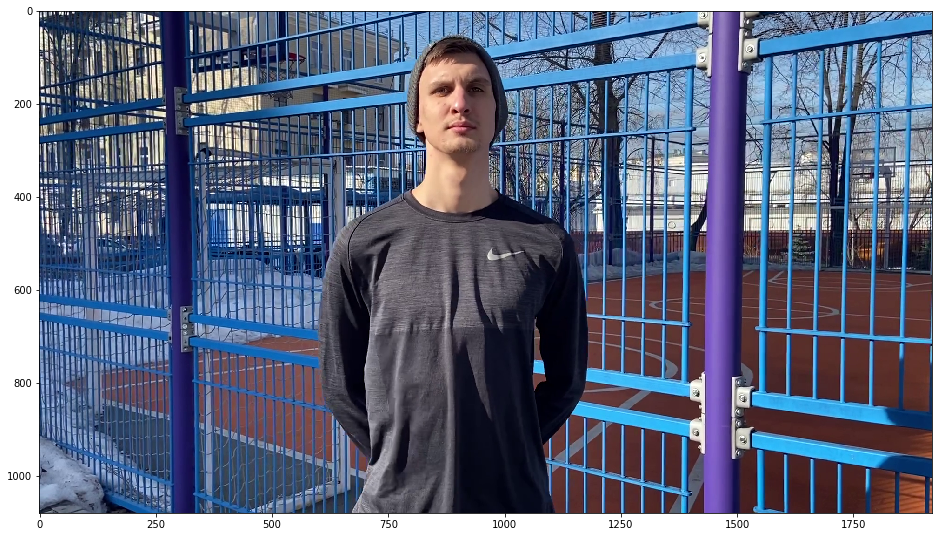

In [3]:
#IMG_PATH = 'imgs/04.jpg'

#img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)

cap = cv2.VideoCapture('template_vid.MOV')

for i in range(30):
    ret, frame = cap.read()

img_ori = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 16))
plt.imshow(img_ori)

In [4]:
cv2.imwrite('debik.jpg', frame)

True

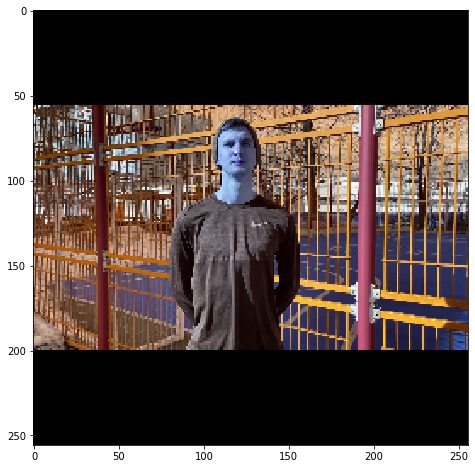

In [5]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

def preprocess(img):
    im = np.zeros((256, 256, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / 256
        new_width = int(img.shape[1] / scale)
        diff = (256 - new_width) // 2
        img = cv2.resize(img, (new_width, 256))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (256 - new_height) // 2
        img = cv2.resize(img, (256, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

img = preprocess(frame)

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [6]:
input_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.

pred = model.predict(input_img)

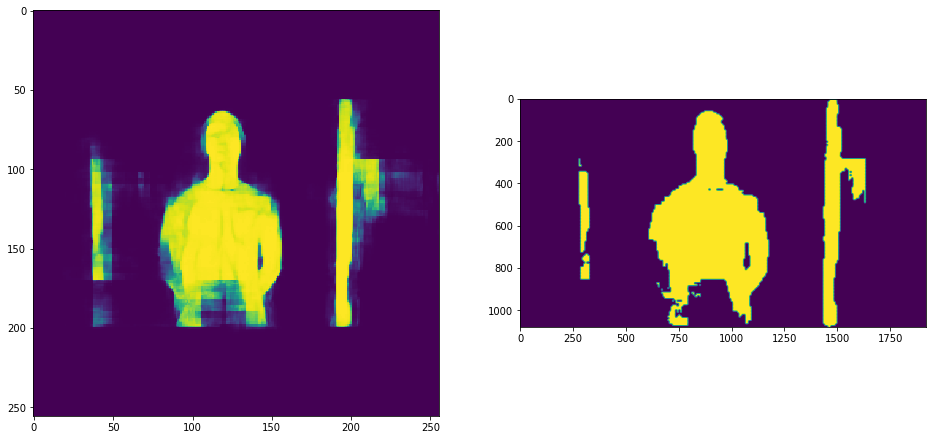

In [7]:
THRESHOLD = 0.8
EROSION = 1

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]
    
    mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
    max_size = max(h, w)
    result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

    if h >= w:
        diff = (max_size - w) // 2
        if diff > 0:
            result_mask = result_mask[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        if diff > 0:
            result_mask = result_mask[diff:-diff, :]
        
    result_mask = cv2.resize(result_mask, dsize=(w, h))
    
    # fill holes
#     cv2.floodFill(result_mask, mask=np.zeros((h+2, w+2), np.uint8), seedPoint=(0, 0), newVal=255)
#     result_mask = cv2.bitwise_not(result_mask)
    result_mask *= 255

#     # erode image
#     element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*EROSION + 1, 2*EROSION+1), (EROSION, EROSION))
#     result_mask = cv2.erode(result_mask, element)

    # smoothen edges
    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)
    
    return result_mask

mask = postprocess(img_ori, pred)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)

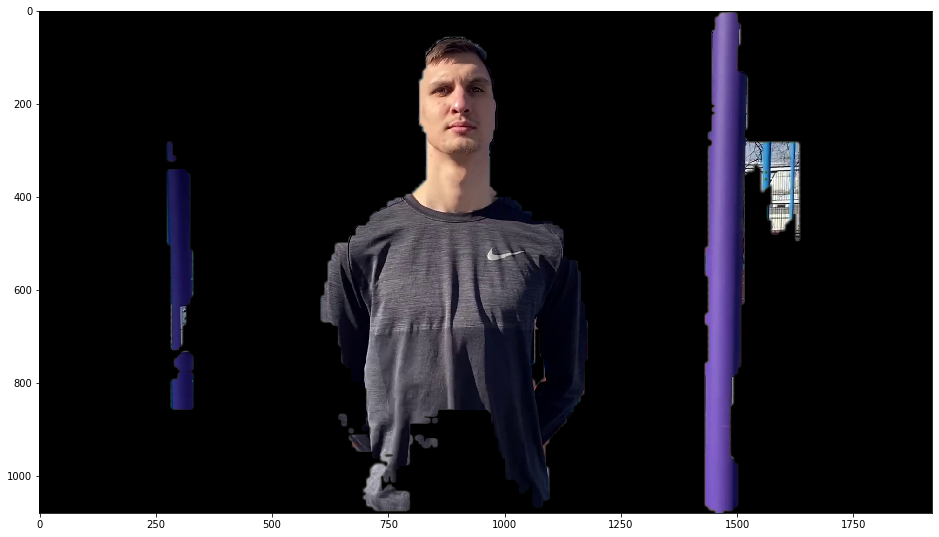

In [8]:
converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

result_img = cv2.subtract(converted_mask, img_ori)
result_img = cv2.subtract(converted_mask, result_img)

plt.figure(figsize=(16, 16))
plt.imshow(result_img)

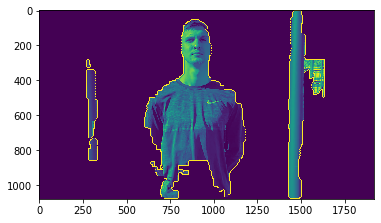

In [9]:
gray = cv2.cvtColor(result_img, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray, 1, 255, 0)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

if len(contours) != 0:
    # draw in blue the contours that were founded
    cv2.drawContours(gray, contours, -1, 255, 3)

    # find the biggest countour (c) by the area
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    max_contour_area = cv2.contourArea(c)
    
    for i in contours:
        if cv2.contourArea(i) < max_contour_area:
            x,y,w,h = cv2.boundingRect(i)
            cv2.rectangle(result_img,(x,y),(x+w,y+h),(0,0,0),-1)
    


    
    
    
plt.imshow(gray)

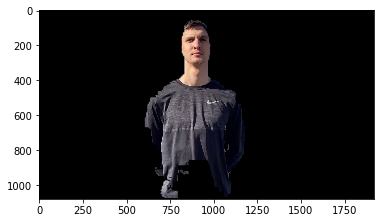

In [10]:
plt.imshow(result_img)

In [11]:
def preprocess(img):
    im = np.zeros((256, 256, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / 256
        new_width = int(img.shape[1] / scale)
        diff = (256 - new_width) // 2
        img = cv2.resize(img, (new_width, 256))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (256 - new_height) // 2
        img = cv2.resize(img, (256, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]
    
    mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
    max_size = max(h, w)
    result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

    if h >= w:
        diff = (max_size - w) // 2
        if diff > 0:
            result_mask = result_mask[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        if diff > 0:
            result_mask = result_mask[diff:-diff, :]
        
    result_mask = cv2.resize(result_mask, dsize=(w, h))
    
    result_mask *= 255

    # smoothen edges
    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)
    
    return result_mask


def process_frame(frame):
    img_ori = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
    
    img = preprocess(frame)
    input_img = img.reshape((1, 256, 256, 3)).astype(np.float32) / 255.

    pred = model.predict(input_img)
    
    THRESHOLD = 0.8
    EROSION = 1
    
    mask = postprocess(img_ori, pred)
    
    converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    result_img = cv2.subtract(converted_mask, img_ori)
    result_img = cv2.subtract(converted_mask, result_img)
    
    gray = cv2.cvtColor(result_img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray, 1, 255, 0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) != 0:
        # draw in blue the contours that were founded
        cv2.drawContours(gray, contours, -1, 255, 3)

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        max_contour_area = cv2.contourArea(c)

        for i in contours:
            if cv2.contourArea(i) < max_contour_area:
                x,y,w,h = cv2.boundingRect(i)
                cv2.rectangle(result_img,(x,y),(x+w,y+h),(0,0,0),-1)
                
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    return result_img

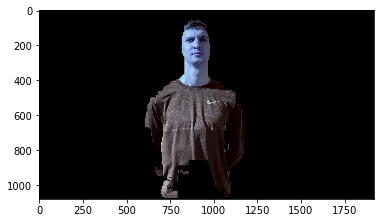

In [12]:
re = process_frame(frame)
plt.imshow(re)

In [61]:
w,h,_ = re.shape
w*h

2073600

In [59]:
number = np.sum(re)
not_black = np.sum(re != 0)
not_black, number

(943401, 67270316)

In [63]:
import cv2
import numpy as np

# Create a VideoCapture object
cap = cv2.VideoCapture('Chelik_big.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('chelikbig.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True: 

        seg_frame = process_frame(frame)
        out.write(seg_frame)

        # Display the resulting frame    
    # Break the loop
    else:
        break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

In [44]:
# overlay function
def overlay_transparent(background_img, img_to_overlay_t, mask, x, y, overlay_size=None):
    img_to_overlay_t = cv2.cvtColor(img_to_overlay_t, cv2.COLOR_RGB2RGBA)
    bg_img = background_img.copy()

    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2RGBA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)
        
    print(mask.shape)
    print(bg_img.shape)

    mask = cv2.medianBlur(mask, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
    
    print(roi.shape)

    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

    # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGBA2RGB)

    return bg_img

overlay_img = cv2.resize(result_img, dsize=None, fx=0.4, fy=0.4)
resized_mask = cv2.resize(mask, dsize=None, fx=0.4, fy=0.4)

out_img = overlay_transparent(bg_img, overlay_img, resized_mask, 150, 300)

plt.figure(figsize=(16, 16))
plt.imshow(out_img)

(432, 768)
(500, 333, 4)
(416, 234, 4)


error: OpenCV(4.4.0) /tmp/pip-req-build-nzyrw1vf/opencv/modules/core/src/arithm.cpp:250: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'
